In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
mpl.rcParams["figure.facecolor"] = "white" # Set figure background to white for notebook with dark mode


def correlation_function(distance,i=2):
    """Exponential correlation function."""
    return np.exp(-distance**i)

def compute_correlation_matrix(grid,kernel, bx,by):
    """Compute the correlation matrix for a 2D grid."""
    N = grid.shape[0]
    C = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            d = np.sqrt(((grid[i, 0] - grid[j, 0])/bx)**2 + ((grid[i, 1] - grid[j, 1])/by)**2)
            C[i, j] = kernel(d)
    return C


def KL_expansion(grid, kernel, C_param,truncation_order):
    """Compute the KL expansion."""
    N = grid.shape[0]
    mu = C_param[0]
    sigma = C_param[1]
    bx = C_param[2]
    by = C_param[3]
    C = compute_correlation_matrix(grid, kernel, bx, by)
    eig_values, eig_vectors = np.linalg.eigh(C)
    # Sort eigenvalues and eigenvectors
    idx = eig_values.argsort()[::-1]
    eig_values = eig_values[idx]
    eig_vectors = eig_vectors[:, idx]

    return eig_values[:truncation_order], eig_vectors[:, :truncation_order]

C11param = [ 1.55, 0.129, 50, 50]   # = [ mu, sigma , bx, by] 
C33param = [ 0.316, 0.027, 50, 50]

# Parameters
n_points = 27
Lmax = 100
N = n_points**2  # Grid size
Nsim = 3  # Number of simulations

# Create 2D grid
x_pde = np.linspace(0, Lmax, int(np.sqrt(N)))
y = np.linspace(0, Lmax, int(np.sqrt(N)))
X, Y = np.meshgrid(x_pde, y)
grid = np.column_stack((X.ravel(), Y.ravel()))

# Spectral decomposition
eig_values_C11, eig_vectors_C11 = KL_expansion(grid, correlation_function, C11param, N)
eig_values_C33, eig_vectors_C33 = KL_expansion(grid, correlation_function, C33param, N)

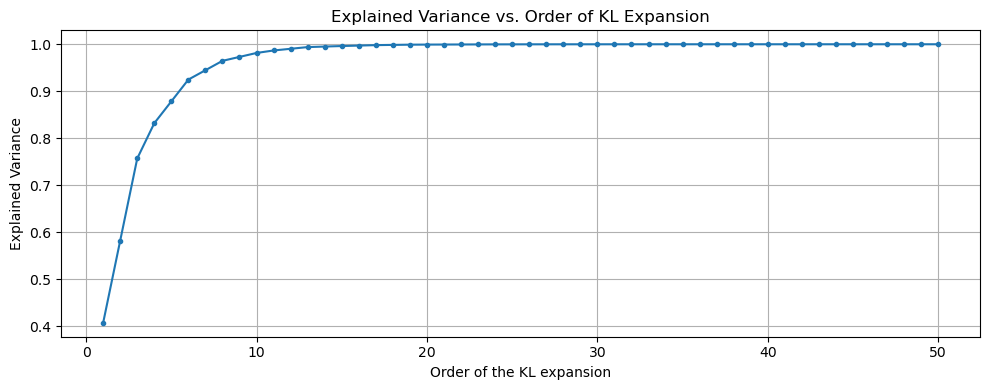

Truncation order for 95.0% explained variance: 8


In [3]:
explained_variance = np.cumsum(eig_values_C11) / np.sum(eig_values_C11)
plt.figure(figsize=(10, 4))
n_orders = 50
plt.plot(np.arange(1, n_orders + 1), explained_variance[:n_orders], marker='.')
plt.xlabel('Order of the KL expansion')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs. Order of KL Expansion')
plt.grid(True)
plt.tight_layout()
plt.show()

# Propose truncation order based on a threshold
threshold = 0.95  # Example threshold for 99% explained variance
truncation_order = np.argmax(explained_variance >= threshold) + 1
print(f"Truncation order for {threshold*100}% explained variance: {truncation_order}")


In [233]:
# truncation_order = 248

def C_from_xi(xi, eig_values, eig_vectors, C_param):
    """Compute the Gaussian Random Field from the KL expansion."""
    N = eig_vectors.shape[0]
    XC = eig_vectors @ (np.sqrt(eig_values) * xi).T
    C = np.exp(C_param[0] + C_param[1] * XC)
    C = C.reshape((int(np.sqrt(N)), int(np.sqrt(N)), Nsim))
    return C

eig_values_C11, eig_vectors_C11 = KL_expansion(grid, correlation_function, C11param, truncation_order)
eig_values_C33, eig_vectors_C33 = KL_expansion(grid, correlation_function, C33param, truncation_order)

# Simulate Gaussian Random Field using K-L expansion
U_C11 = np.random.randn(Nsim,truncation_order)
U_C33 = np.random.randn(Nsim,truncation_order)

# Compute random coefficients
C11 = C_from_xi(U_C11, eig_values_C11, eig_vectors_C11, C11param)
C33 = C_from_xi(U_C33, eig_values_C33, eig_vectors_C33, C33param)

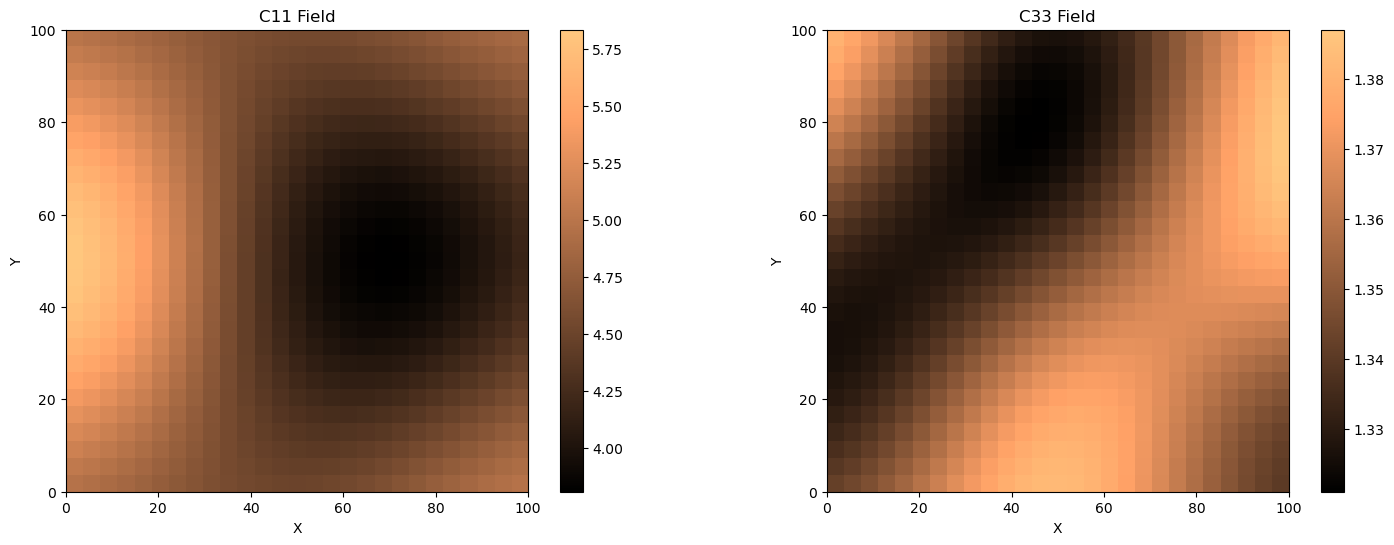

In [5]:
C11_plot = C11[:,:,0].squeeze()
C33_plot = C33[:,:,0].squeeze()
# Visualization
fig,ax = plt.subplots(1,2,figsize=(18,6))

imC11 = ax[0].imshow(C11_plot, extent=[0, Lmax, 0, Lmax], origin='lower', aspect='auto', cmap='copper')
fig.colorbar(imC11, ax=ax[0])
ax[0].set_title('C11 Field')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].set_aspect('equal', 'box')

imC33 = ax[1].imshow(C33_plot, extent=[0, Lmax, 0, Lmax], origin='lower', aspect='auto', cmap='copper')
fig.colorbar(imC33, ax=ax[1])
ax[1].set_title('C33 Field')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
ax[1].set_aspect('equal', 'box')

In [234]:
from scipy.interpolate import RegularGridInterpolator

# Function to calculate the derivative using the interpolated function
def derivative_interp(interp_func, x, y, axis, bounds,delta=1e-6):
    if axis == 'x':
        if x - delta < bounds[0] :
            return (interp_func((x + delta, y)) - interp_func((x, y))) / (delta)
        elif x + delta > bounds[1]:
            return (interp_func((x, y)) - interp_func((x - delta, y))) / (delta)
        else:
            return (interp_func((x + delta, y)) - interp_func((x - delta, y))) / (2 * delta)
    elif axis == 'y':
        if y - delta < bounds[0]:
            return (interp_func((x, y + delta)) - interp_func((x, y))) / (delta)
        elif y + delta > bounds[1]:
            return (interp_func((x, y)) - interp_func((x, y - delta))) / (delta)
        else:
            return (interp_func((x, y + delta)) - interp_func((x, y - delta))) / (2 * delta)

def calculate_derivatives(C):
    x = np.linspace(0, Lmax, C.shape[0])
    y = np.linspace(0, Lmax, C.shape[1])

    C_dx = np.zeros_like(C)
    C_dy = np.zeros_like(C)

    for i in range(C.shape[2]):
        C_matrix = C[:,:,i].squeeze()
        C_interp = RegularGridInterpolator((x, y), C_matrix.T, method='cubic')
        # C_interp = lambda x: interp2d(x[0], x[1], C_matrix, kind='cubic')

        for j in range(n_points):
            for k in range(n_points):
                C_dx[j, k,i] = derivative_interp(C_interp, x[k], y[j], 'x',bounds=[0,Lmax]) 
                C_dy[j, k,i] = derivative_interp(C_interp, x[k], y[j], 'y',bounds=[0,Lmax])

    return C_dx, C_dy

# Calculate derivatives on the grid
C11_dx, C11_dy = calculate_derivatives(C11)
C33_dx, C33_dy = calculate_derivatives(C33)

# Visualization
C11_plot = C11[:,:,0].squeeze()
C33_plot = C33[:,:,0].squeeze()

C11_dx_plot = C11_dx[:,:,0].squeeze()
C11_dy_plot = C11_dy[:,:,0].squeeze()
C33_dx_plot = C33_dx[:,:,0].squeeze()
C33_dy_plot = C33_dy[:,:,0].squeeze()    


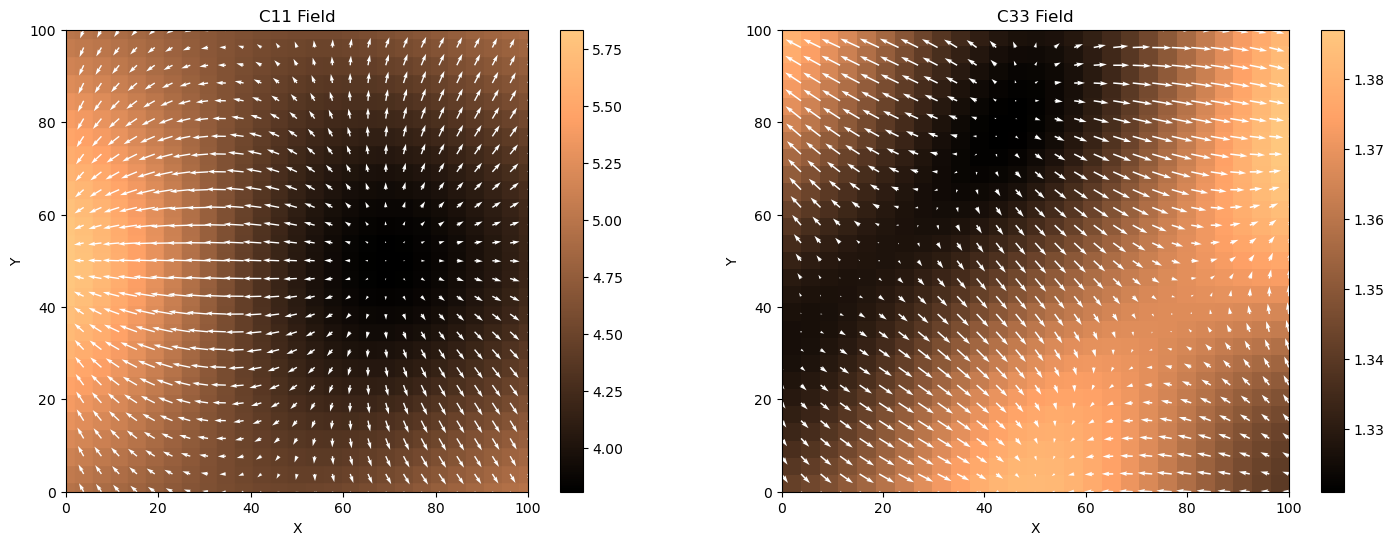

In [7]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

# imC11 = ax[0].imshow(C11_plot, extent=[0, Lmax, 0, Lmax], origin='lower', aspect='auto', cmap='copper')
scat = ax[0].scatter(X.ravel(), Y.ravel(), c=C11_plot.ravel(), s=150,cmap='copper',marker='s')
ax[0].set_aspect('equal', adjustable='box')
# fig.colorbar(imC11, ax=ax[0])
fig.colorbar(scat, ax=ax[0])
ax[0].set_xlim([0,Lmax])
ax[0].set_ylim([0,Lmax])
ax[0].set_title('C11 Field')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')

imC33 = ax[1].imshow(C33_plot, extent=[0, Lmax, 0, Lmax], origin='lower', aspect='auto', cmap='copper')
fig.colorbar(imC33, ax=ax[1])
ax[1].set_title('C33 Field')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')

scale_C11 = max(np.max(np.abs(C11_dx)), np.max(np.abs(C11_dy)))*20/Lmax # Scale factor for the gradient
scale_C33 = max(np.max(np.abs(C33_dx)), np.max(np.abs(C33_dy)))*20/Lmax # Scale factor for the gradient

# Create a meshgrid for visualization
x = np.linspace(0, Lmax, n_points)
y = np.linspace(0, Lmax, n_points)
X, Y = np.meshgrid(x, y)

#plot gradient
for j in range(n_points):
    for k in range(n_points):
        ax[0].quiver(X[j, k], Y[j, k], C11_dx_plot[j, k] , C11_dy_plot[j, k], 
                  color='white', scale=scale_C11, scale_units='xy', angles='xy', width=0.003)
        ax[1].quiver(X[j, k], Y[j, k], C33_dx_plot[j, k], C33_dy_plot[j, k], 
                  color='white', scale=scale_C33, scale_units='xy', angles='xy', width=0.003)


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import time


# Ensure reproducibility
torch.manual_seed(0)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
def grad_i(Y,X,i):
    #calculate the partial derivative of y with respect to x_i
    return torch.autograd.grad(Y, X, grad_outputs=torch.ones_like(Y), create_graph=True)[0][:, None, i].flatten()
print("Using GPU:", torch.cuda.is_available())

Using GPU: False


In [251]:

def E_nn(U,X):
    #calculate the strain given the displacement
    # u is the output of the NN, a tensor of shape (N,2)
    Exx = grad_i(U[0],X,0)
    Eyy = grad_i(U[1],X,1)
    Exy = 0.5 * (grad_i(U[1],X,0) +grad_i(U[0],X,1))
    return [Exx, Eyy, Exy]

def S_nn(E, C11, C33):
    """
    Compute the stress for the given strain and stiffness coefficients.

    Parameters:
    - X (N*2): 2D spatial coordinates.
    - strain (N*3): Strains at each spatial coordinate (epsilon_x, epsilon_y, gamma_xy).
    - C11 (Nc*Nc): Coefficients for the stiffness matrix.
    - C33 (Nc*Nc): Coefficients for the stiffness matrix.
    - Lmax: Maximum limit for the 2D spatial grid.

    Returns:
    - stress (N*3): Stress at each spatial coordinate (sigma_x, sigma_y, tau_xy).
    """

    Exx, Eyy, Exy = E

    Sxx = C11 * (Exx + Eyy) - 2*C33 * Eyy
    Syy = C11 * (Exx + Eyy) - 2*C33 * Exx
    Sxy = 2*C33 * Exy

    return [Sxx, Syy, Sxy]

def compute_PDE(X, E, C_data):

    C11, dC11_dx, dC11_dy,C33,dC33_dx, dC33_dy = C_data
    Exx, Eyy, Exy = E 

    # Sxx, Syy, Sxy = S_nn(E, C11, C33)
    # dSxx_dx = grad_i(Sxx,X,0)
    # dSyy_dy = grad_i(Syy,X,1)
    # dSxy_dx = grad_i(Sxy,X,0)
    # dSxy_dy = grad_i(Sxy,X,1)

    # Mx = dSxx_dx + dSxy_dy
    # My = dSyy_dy + dSxy_dx 
    dExx_dx = grad_i(Exx,X,0)
    dExx_dy = grad_i(Exx,X,1)
    dEyy_dx = grad_i(Eyy,X,0)
    dEyy_dy = grad_i(Eyy,X,1)
    dExy_dx = grad_i(Exy,X,0)
    dExy_dy = grad_i(Exy,X,1)
 
    Mx = dC11_dx * (Exx + Eyy) + C11 * (dExx_dx + dEyy_dx) - 2*dC33_dx * Eyy - 2*C33 * dEyy_dx + 2*dC33_dy * Exy + 2*C33 * dExy_dy
    My = dC11_dy * (Exx + Eyy) + C11 * (dExx_dy + dEyy_dy) - 2*dC33_dy * Exx - 2*C33 * dExx_dy + 2*dC33_dx * Exy + 2*C33 * dExy_dx

    return [Mx, My]


def Enforce_BC(x,Ux,Uy):

    Ux = Ux*x[:,0]
    Uy = Uy*x[:,1]
    return [Ux,Uy]


def static_sampling(domain,n_samples, sampling_strat):
    """Generate a static sampling strategy for the domain.
    "random","LHS" are stochastic
    "grid","Halton","Hammersley","Sobol" are deterministic
    Parameters
    ----------
    domain:[[XMIN, XMAX], [YMIN, YMAX]]
        The domain of the problem.
    n_samples: int
        The number of samples.
    sampling_strat: str
        The sampling strategy.
    Returns
    -------
    X: numpy.ndarray
        The generated samples.
    """
    if sampling_strat == "Random":
        X = np.random.uniform(domain[0][0], domain[0][1], n_samples)
        Y = np.random.uniform(domain[1][0], domain[1][1], n_samples)
        X = np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))
        return X
    elif sampling_strat == "Grid":
        X = np.linspace(domain[0][0], domain[0][1], int(np.sqrt(n_samples)))
        Y = np.linspace(domain[1][0], domain[1][1], int(np.sqrt(n_samples)))
        X, Y = np.meshgrid(X, Y)
        X = X.reshape(-1, 1)
        Y = Y.reshape(-1, 1)
        X = np.hstack((X, Y))
        return X
     
    elif sampling_strat == "LHS":
        sampler = skopt.sampler.Lhs(lhs_type="centered", criterion="maximin", iterations=1000)
    elif sampling_strat == "Halton":
        sampler = skopt.sampler.Halton(min_skip=-1, max_skip=-1)
    elif sampling_strat == "Hammersley":
        sampler = skopt.sampler.Hammersly(min_skip=-1, max_skip=-1)
    elif sampling_strat == "Sobol":
        # Remove the first point [0, 0, ...] and the second point [0.5, 0.5, ...], which
        # are too special and may cause some error.
        sampler = skopt.sampler.Sobol(skip=0, randomize=False)
        return np.array(sampler.generate(domain, n_samples + 2)[2:])
    return np.array(sampler.generate(domain, n_samples))

In [200]:
def hermite_polynomial(order, xi):
    """Compute the Hermite polynomial of a given order for xi."""
    if order == 0:
        return torch.ones_like(xi)
    elif order == 1:
        return xi
    else:
        H0 = torch.ones_like(xi)
        H1 = xi
        for _ in range(2, order + 1):
            H_next = xi * H1 - (order - 1) * H0
            H0, H1 = H1, H_next
        return H1

def generate_pce_basis(xi, max_order):
    """Generate PCE basis up to a given order for xi."""
    basis = []
    for order in range(max_order + 1):
        basis.append(hermite_polynomial(order, xi))
    return torch.stack(basis, dim=-1)

class MeanNN(nn.Module):
    """Neural network to approximate the mean function."""
    def __init__(self, input_dim, hidden_dim=4, output_dim=1):
        super(MeanNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


class CoefficientNN(nn.Module):
    """Neural network to approximate the coefficients of the PCE."""
    def __init__(self, input_dim, hidden_dim=32, output_dim=None):
        super(CoefficientNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
    
def U_nn(x, xi, Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs, Enforce_BC):
    """Compute the total predicted u."""
    pce_basis = hermite_polynomial(1, xi)
    Ux = Ux_mean(x).flatten() #+ pce_basis @  Ux_coeffs(x).T
    Uy = Uy_mean(x).flatten() #+ pce_basis @  Uy_coeffs(x).T
    Ux, Uy = Enforce_BC(x,Ux,Uy)
    return Ux, Uy

def l2_regularization(model):
    l2_reg = None
    for W in model.parameters():
        if l2_reg is None:
            l2_reg = W.norm(2)
        else:
            l2_reg = l2_reg + W.norm(2)
    return l2_reg
    
def compute_loss(x_pde,x_bc, xi, Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs, C_data,batch_size,pstress=0.1):
    
    C11, dC11_dx, dC11_dy, C33, dC33_dx, dC33_dy = C_data

    indices = torch.randperm(xi.size(0))[:batch_size]
    xi_batch = xi[indices]
    C11_batch = C11[:,:,indices]
    dC11_dx_batch = dC11_dx[:,:,indices]
    dC11_dy_batch = dC11_dy[:,:,indices]
    C33_batch = C33[:,:,indices]
    dC33_dx_batch = dC33_dx[:,:,indices]
    dC33_dy_batch = dC33_dy[:,:,indices]
    pde_loss = 0
    bc_loss = 0
    
    for i in range(batch_size):        
        # Compute the total predicted u
        U_pde = U_nn(x_pde, xi_batch[i], Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs, Enforce_BC)

        E_pde = E_nn(U_pde,x_pde)

        C_data_batch = [C11_batch[:,:,i], dC11_dx_batch[:,:,i], dC11_dy_batch[:,:,i], C33_batch[:,:,i], dC33_dx_batch[:,:,i], dC33_dy_batch[:,:,i]]
        C11_bc = C11_batch[:,-1,i]
        C33_bc = C33_batch[:,-1,i]

        for C_index,C in enumerate(C_data_batch):
            C_data_batch[C_index] = C.ravel()

        # Compute the stress
        # S = S_nn(x, E, C11_batch[:,:,i].squeeze(), C33_batch[:,:,i].squeeze())

        Mx,My = compute_PDE(x_pde, E_pde, C_data_batch)
        pde_loss += torch.mean((Mx**2 + My**2))/len(x_pde)
        # Boundary Conditions Loss on stress
        U_bc = U_nn(x_bc, xi_batch[i], Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs, Enforce_BC)
        E_bc = E_nn(U_bc,x_bc)
        S_bc = S_nn(E_bc, C11_bc, C33_bc)
        bc_loss += torch.mean((S_bc[0] - pstress)**2)/len(x_bc) 
        
        # Combine the losses
    pde_loss = pde_loss / batch_size
    bc_loss = bc_loss / batch_size 
    return pde_loss, bc_loss

In [172]:
def train(Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs, xi, C_data, batch_size=100, epochs=1000, lr=0.001, lambda_reg=1e-4,lambda_bc=1, N = 27,sampling = 'Grid',pstress=0.1,opt='Adam',print_every=100):
    device = xi.device
    t_start = time.time()
    x_pde = torch.tensor(static_sampling([[0, Lmax], [0, Lmax]], N**2, sampling)).float().to(device)
    x_pde.requires_grad = True
    x_bc = torch.ones((N,2))*Lmax
    x_bc[:,1] = torch.linspace(0,Lmax,N).float()
    x_bc = x_bc.to(device)
    x_bc.requires_grad = True
    

    if opt == 'Adam':

        # optimizer = torch.optim.Adam(list(Ux_mean.parameters()) + list(Ux_coeffs.parameters()) + list(Uy_mean.parameters()) + list(Uy_coeffs.parameters()), lr=lr)
        optimizer = torch.optim.Adam(list(Ux_mean.parameters()), lr=lr)

        for epoch in range(epochs):
            optimizer.zero_grad()
            
            pde_loss,bc_loss = compute_loss(x_pde,x_bc, xi, Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs,C_data, batch_size,pstress=pstress)
            l2_reg = l2_regularization(Ux_mean) + l2_regularization(Ux_coeffs) + l2_regularization(Uy_mean) + l2_regularization(Uy_coeffs)
            loss = pde_loss + lambda_reg*l2_reg + lambda_bc*bc_loss
            loss.backward()
            optimizer.step()
            
            # Print progress
            if epoch % print_every == 0:
                print(f"Epoch {epoch}, Loss: {loss.item():.3e}, PDE loss: {pde_loss.item():.3e}, BC loss: {bc_loss.item():.3e}, l2 reg: {l2_reg.item():.3e}, Elapsed time: {time.time()-t_start:.0f}")

    elif opt == 'LBFGS':
        optimizer = torch.optim.LBFGS(list(Ux_mean.parameters()), lr=lr)
        def closure():
            optimizer.zero_grad()
            pde_loss,bc_loss = compute_loss(x_pde,x_bc, xi, Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs,C_data, batch_size,pstress=pstress)
            l2_reg = l2_regularization(Ux_mean) + l2_regularization(Ux_coeffs) + l2_regularization(Uy_mean) + l2_regularization(Uy_coeffs)
            loss = pde_loss + lambda_reg*l2_reg + lambda_bc*bc_loss
            loss.backward()
            return loss
        for epoch in range(epochs):
            optimizer.step(closure)
            # Print progress
            if epoch % print_every == 0:
                pde_loss,bc_loss = compute_loss(x_pde,x_bc, xi, Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs,C_data, batch_size,pstress=pstress)
                l2_reg = l2_regularization(Ux_mean) + l2_regularization(Ux_coeffs) + l2_regularization(Uy_mean) + l2_regularization(Uy_coeffs)
                print(f"Epoch {epoch}, Loss: {closure().item():.3e}, PDE loss: {pde_loss.item():.3e}, BC loss: {bc_loss.item():.3e}, l2 reg: {l2_reg.item():.3e}, Elapsed time: {time.time()-t_start:.0f}")
    
    pde_loss,bc_loss = compute_loss(x_pde,x_bc, xi, Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs,C_data, batch_size,pstress=pstress)
    l2_reg = l2_regularization(Ux_mean) + l2_regularization(Ux_coeffs) + l2_regularization(Uy_mean) + l2_regularization(Uy_coeffs)
    loss = pde_loss + lambda_reg*l2_reg + lambda_bc*bc_loss

    print(f"Epoch {epoch}, Loss: {loss.item():.3e}, PDE loss: {pde_loss.item():.3e}, BC loss: {bc_loss.item():.3e}, l2 reg: {l2_reg.item():.3e}, Elapsed time: {time.time()-t_start:.0f}")
    return Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs


In [246]:
Lmax = 100
N = 729  # Grid size
Nsim = 1  # Number of simulations
truncation_order = 8

# Create 2D grid
x_pde = np.linspace(0, Lmax, int(np.sqrt(N)))
y = np.linspace(0, Lmax, int(np.sqrt(N)))
X, Y = np.meshgrid(x_pde, y)
grid = np.column_stack((X.ravel(), Y.ravel()))

C11param = [ 1.55, 0, 50, 50]   # = [ mu, sigma , bx, by]
C33param = [ 0.316, 0, 50, 50]

eig_values_C11, eig_vectors_C11 = KL_expansion(grid, correlation_function, C11param, truncation_order)
eig_values_C33, eig_vectors_C33 = KL_expansion(grid, correlation_function, C33param, truncation_order)

# Simulate Gaussian Random Field using K-L expansion
U_C11 = np.random.randn(Nsim,truncation_order)
U_C33 = np.random.randn(Nsim,truncation_order)
xi = torch.cat((torch.tensor(U_C11).float(),torch.tensor(U_C33).float()),dim=1).to(device)
# Compute random coefficients
C11 = C_from_xi(U_C11, eig_values_C11, eig_vectors_C11, C11param)
C33 = C_from_xi(U_C33, eig_values_C33, eig_vectors_C33, C33param)

dC11_dx, dC11_dy = calculate_derivatives(C11)
dC33_dx, dC33_dy = calculate_derivatives(C33)
C11 = torch.tensor(C11).float().to(device)
C33 = torch.tensor(C33).float().to(device)
C_data = (C11, torch.tensor(dC11_dx).float().to(device), torch.tensor(dC11_dy).float().to(device), C33, torch.tensor(dC33_dx).float().to(device), torch.tensor(dC33_dy).float().to(device)) 

# Models, Loss, and Optimizer
Ux_mean = MeanNN(input_dim=2).to(device)
Ux_coeffs = CoefficientNN(input_dim=2, output_dim=truncation_order*2).to(device)
Uy_mean = MeanNN(input_dim=2).to(device)
Uy_coeffs = CoefficientNN(input_dim=2, output_dim=truncation_order*2).to(device)



In [252]:
load_models = False
save_folder = "saved_models"
if load_models:
    Ux_mean.load_state_dict(torch.load(os.path.join(save_folder, "Ux_mean.pth"), map_location=torch.device(device)))
    Ux_coeffs.load_state_dict(torch.load(os.path.join(save_folder, "Ux_coeffs.pth"), map_location=torch.device(device)))
    Uy_mean.load_state_dict(torch.load(os.path.join(save_folder, "Uy_mean.pth"), map_location=torch.device(device)))
    Uy_coeffs.load_state_dict(torch.load(os.path.join(save_folder, "Uy_coeffs.pth"), map_location=torch.device(device)))
    print("Models loaded.")
    
# Training
batch_size = 1
opt = ['Adam','LBFGS'][0]
learning_rate = 5e-2
lambda_bc = 1
lambda_reg = 5e-10
epochs = 1000
print_every = 100

C_data = [C11, torch.tensor(dC11_dx).float().to(device), torch.tensor(dC11_dy).float().to(device), C33, torch.tensor(dC33_dx).float().to(device), torch.tensor(dC33_dy).float().to(device)] 

Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs = train(Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs, xi, C_data, batch_size=batch_size, epochs=epochs, lr=learning_rate, lambda_reg=lambda_reg,lambda_bc=lambda_bc,N = 27,sampling = 'Grid',opt=opt,print_every=print_every)

Models loaded.
Epoch 0, Loss: 6.907e-07, PDE loss: 2.097e-08, BC loss: 6.688e-07, l2 reg: 1.964e+00, Elapsed time: 0
Epoch 100, Loss: 3.251e-08, PDE loss: 1.138e-08, BC loss: 1.983e-08, l2 reg: 2.594e+00, Elapsed time: 3
Epoch 200, Loss: 2.010e-08, PDE loss: 1.138e-08, BC loss: 7.424e-09, l2 reg: 2.593e+00, Elapsed time: 5
Epoch 300, Loss: 2.005e-08, PDE loss: 1.136e-08, BC loss: 7.391e-09, l2 reg: 2.593e+00, Elapsed time: 7
Epoch 400, Loss: 2.003e-08, PDE loss: 1.135e-08, BC loss: 7.391e-09, l2 reg: 2.593e+00, Elapsed time: 11
Epoch 500, Loss: 2.002e-08, PDE loss: 1.133e-08, BC loss: 7.391e-09, l2 reg: 2.592e+00, Elapsed time: 13
Epoch 600, Loss: 1.999e-08, PDE loss: 1.131e-08, BC loss: 7.391e-09, l2 reg: 2.592e+00, Elapsed time: 15
Epoch 700, Loss: 1.997e-08, PDE loss: 1.128e-08, BC loss: 7.391e-09, l2 reg: 2.591e+00, Elapsed time: 17
Epoch 800, Loss: 1.994e-08, PDE loss: 1.125e-08, BC loss: 7.391e-09, l2 reg: 2.591e+00, Elapsed time: 20
Epoch 900, Loss: 1.991e-08, PDE loss: 1.123e-0

In [236]:
import os

# Create the folder if it doesn't exist
save_folder = "saved_models"
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

save_models = True
if save_models:
    torch.save(Ux_mean.state_dict(), os.path.join(save_folder, "Ux_mean.pt"))
    torch.save(Ux_coeffs.state_dict(), os.path.join(save_folder, "Ux_coeffs.pt"))
    torch.save(Uy_mean.state_dict(), os.path.join(save_folder, "Uy_mean.pt"))
    torch.save(Uy_coeffs.state_dict(), os.path.join(save_folder, "Uy_coeffs.pt"))
    print("Models saved.")

Models saved.


In [253]:
N = 27
# Generate the grid for plotting
x_plot = np.linspace(0, Lmax, int(N))
y_plot = np.linspace(0, Lmax, int(N))
X_plot, Y_plot = np.meshgrid(x_plot, y_plot)

# Create a meshgrid of points
points = np.column_stack((X_plot.ravel(), Y_plot.ravel()))
points_tensor = torch.tensor(points).float().to(device)
points_tensor.requires_grad = True


Ux_mean_plot = Ux_mean(points_tensor).flatten()
Uy_mean_plot = Uy_mean(points_tensor).flatten()
Ux_coeffs_plot = Ux_coeffs(points_tensor).T
Uy_coeffs_plot = Uy_coeffs(points_tensor).T

Ux_mean_plot, Uy_mean_plot = Enforce_BC(points_tensor,Ux_mean_plot,Uy_mean_plot)
Ux_coeffs_plot, Uy_coeffs_plot = Enforce_BC(points_tensor,Ux_coeffs_plot,Uy_coeffs_plot)
Ux_std_plot = torch.sqrt(torch.sum(Ux_coeffs_plot**2, dim=0))
Uy_std_plot = torch.sqrt(torch.sum(Uy_coeffs_plot**2, dim=0))

C11_plot = C11[:,:,0].ravel()
C33_plot = C33[:,:,0].ravel()
E_means = E_nn((Ux_mean_plot,Uy_mean_plot),points_tensor)
S_means = S_nn(E_means, C11_plot, C33_plot)

M_plot = compute_PDE(points_tensor, E_means, C_data)
PDE_loss = M_plot[0]**2 + M_plot[1]**2
M_plot.append(PDE_loss)



for i in range(3):
    E_means[i] = E_means[i].reshape(N, N).cpu().detach().numpy()
    S_means[i] = S_means[i].reshape(N, N).cpu().detach().numpy()
    M_plot[i] = M_plot[i].reshape(N, N).cpu().detach().numpy()


Ux_mean_plot = Ux_mean_plot.reshape(N, N).cpu().detach().numpy()
Uy_mean_plot = Uy_mean_plot.reshape(N, N).cpu().detach().numpy()
Ux_std_plot = Ux_std_plot.reshape(N, N).cpu().detach().numpy()
Uy_std_plot = Uy_std_plot.reshape(N, N).cpu().detach().numpy()
# Reshape the predicted displacement to match the grid shape



with torch.no_grad():
    Ux_pred, Uy_pred = U_nn(points_tensor, xi[0], Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs, Enforce_BC)
Ux_pred = Ux_pred.reshape(N, N).cpu().numpy()
Uy_pred = Uy_pred.reshape(N, N).cpu().numpy()

def pcolor_plot(AX, X, Y, C, title,colormap="copper",**kwargs):
    ## plot the pcolor plot of the given data C on the given axis AX with the given title and optional colorbar limits cmin and cmax
    if len(kwargs) == 0:
        im = AX.pcolor(X, Y, C, cmap=colormap,shading='auto')
    else:
        cmin = kwargs["cmin"]
        cmax = kwargs["cmax"]
        im = AX.pcolor(X, Y, C, cmap=colormap, vmin=cmin, vmax=cmax,shading='auto')
    AX.axis("equal")
    AX.axis("off")
    AX.set_title(title, fontsize=14)
    return im


# fig,ax = plot_field(Mx_plot,My_plot)
# fig.suptitle('Mx', fontsize=24, y=1.05)

fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=100)

for i in range(2):
    im = pcolor_plot(ax[i], X_plot, Y_plot, [Ux_mean_plot, Uy_mean_plot][i],  ["Ux", "Uy"][i])
    fig.colorbar(im, ax=ax[i])

fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=100)
for i in range(3):
    im = pcolor_plot(ax[i], X_plot, Y_plot, E_means[i],  ["Exx", "Eyy", "Exy"][i])
    fig.colorbar(im, ax=ax[i])

fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=100)
for i in range(3):
    im = pcolor_plot(ax[i], X_plot, Y_plot, S_means[i],  ["Sxx", "Syy", "Sxy"][i])
    fig.colorbar(im, ax=ax[i])


fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=100)
for i in range(3):
    im = pcolor_plot(ax[i], X_plot, Y_plot, M_plot[i],  ["Mx", "My","Mx**2+My**2"][i])
    fig.colorbar(im, ax=ax[i])

RuntimeError: shape '[27, 27]' is invalid for input of size 531441

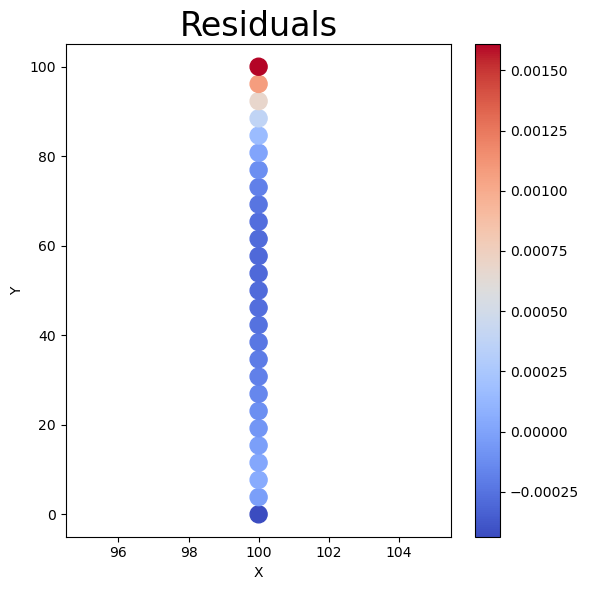

In [221]:
def BC_residual(x_bc, xi, Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs, C_data,p_stress=0.1):
    """Compute the total predicted u."""
    Ux = Ux_mean(x_bc).flatten() #+ pce_basis @  Ux_coeffs(x_bc)
    Uy = Uy_mean(x_bc).flatten() #+ pce_basis @  Uy_coeffs(x_bc)
    Ux, Uy = Enforce_BC(x_bc,Ux,Uy)
    E = E_nn((Ux,Uy),x_bc)
    C11, dC11_dx, dC11_dy, C33, dC33_dx, dC33_dy = C_data
    C11 = C11.reshape(27,27)
    C33 = C33.reshape(27,27)
    C11_bc = C11[:,-1]
    C33_bc = C33[:,-1]
    S = S_nn(E, C11_bc, C33_bc)
    return S[0] - p_stress

def plot_residuals(x_bc, BC_residual):
    """Plot the residuals at the boundary."""
    # Plot the heatmap of the predicted displacement
    x_bc = x_bc.detach().cpu().numpy()
    BC_residual = BC_residual.detach().cpu().numpy()
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    im1 = ax.scatter(x_bc[:, 0], x_bc[:, 1], c=BC_residual, s=150, cmap='coolwarm')
    plt.colorbar(im1,ax=ax)
    plt.xlabel('X')
    plt.ylabel('Y')
    ax.set_title('Residuals',fontsize=24)
    plt.tight_layout()
    return fig,ax

BC_residual = BC_residual(x_bc, xi[0], Ux_mean, Ux_coeffs, Uy_mean, Uy_coeffs, C_data2)
fig,ax = plot_residuals(x_bc, BC_residual)

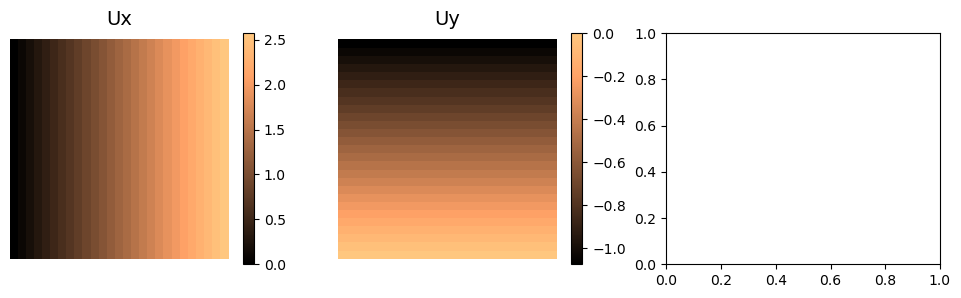

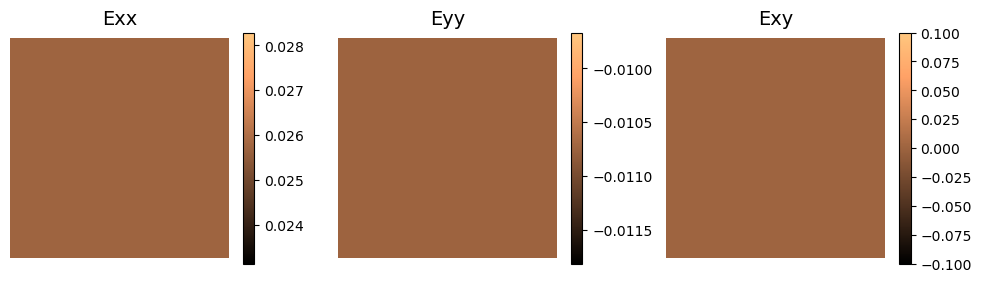

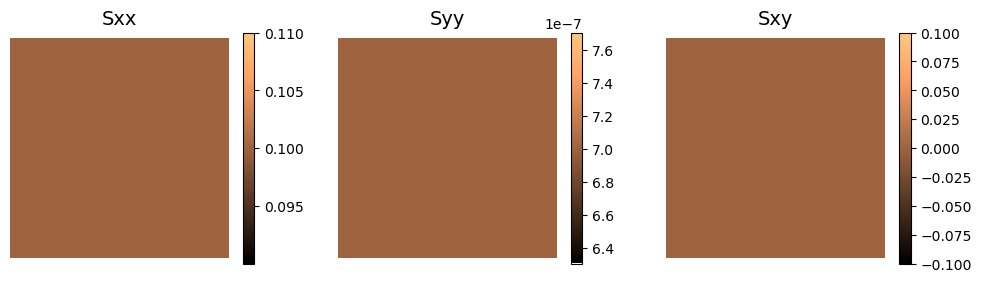

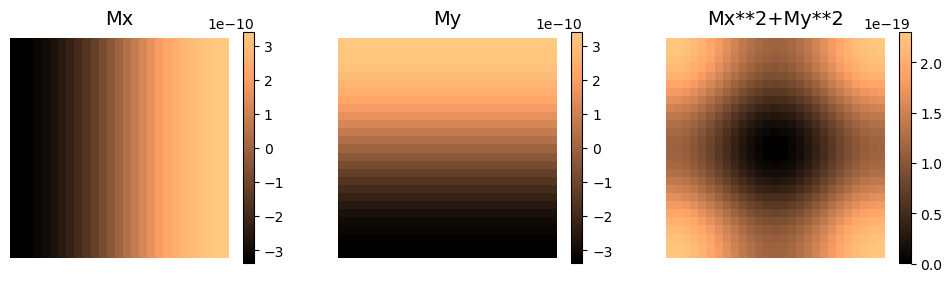

In [250]:
from icecream import ic
N=27

def u_exact(X,delta=1e-10):
    Ux = 0.025712*X[:,0]+delta*torch.cos(np.pi*X[:,0]/Lmax)
    Uy = -0.010741*X[:,1]+delta*torch.cos(np.pi*X[:,1]/Lmax)
    return [Ux,Uy]

C11_plot = C11[:,:,0].ravel()
C33_plot = C33[:,:,0].ravel()

U_exact = u_exact(points_tensor)
E_exact = E_nn(U_exact,points_tensor)
S_exact = S_nn(E_exact, C11_plot, C33_plot)
M_exact = compute_PDE(points_tensor, E_exact, C_data)
PDE_loss = M_exact[0]**2 + M_exact[1]**2
M_exact.append(PDE_loss)


for i in range(3):
    if i<2:
        U_exact[i] = U_exact[i].reshape(N, N).cpu().detach().numpy()
    E_exact[i] = E_exact[i].reshape(N, N).cpu().detach().numpy()
    S_exact[i] = S_exact[i].reshape(N, N).cpu().detach().numpy()
    M_exact[i] = M_exact[i].reshape(N, N).cpu().detach().numpy()



fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=100)
for i in range(2):
    im = pcolor_plot(ax[i], X_plot, Y_plot, U_exact[i],  ["Ux", "Uy"][i])
    fig.colorbar(im, ax=ax[i])

fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=100)
for i in range(3):
    im = pcolor_plot(ax[i], X_plot, Y_plot, E_exact[i],  ["Exx", "Eyy", "Exy"][i])
    fig.colorbar(im, ax=ax[i])

fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=100)
for i in range(3):
    im = pcolor_plot(ax[i], X_plot, Y_plot, S_exact[i],  ["Sxx", "Syy", "Sxy"][i])
    fig.colorbar(im, ax=ax[i])

fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=100)
for i in range(3):
    im = pcolor_plot(ax[i], X_plot, Y_plot, M_exact[i],  ["Mx", "My","Mx**2+My**2"][i])
    fig.colorbar(im, ax=ax[i])


1e-05 : PDE 5.740e-13 ; BC :2.266705398411891e-14
0.0001 : PDE 5.740e-11 ; BC :2.266705398411891e-14
0.001 : PDE 5.740e-09 ; BC :2.266705398411891e-14
0.01 : PDE 5.740e-07 ; BC :2.266705398411891e-14


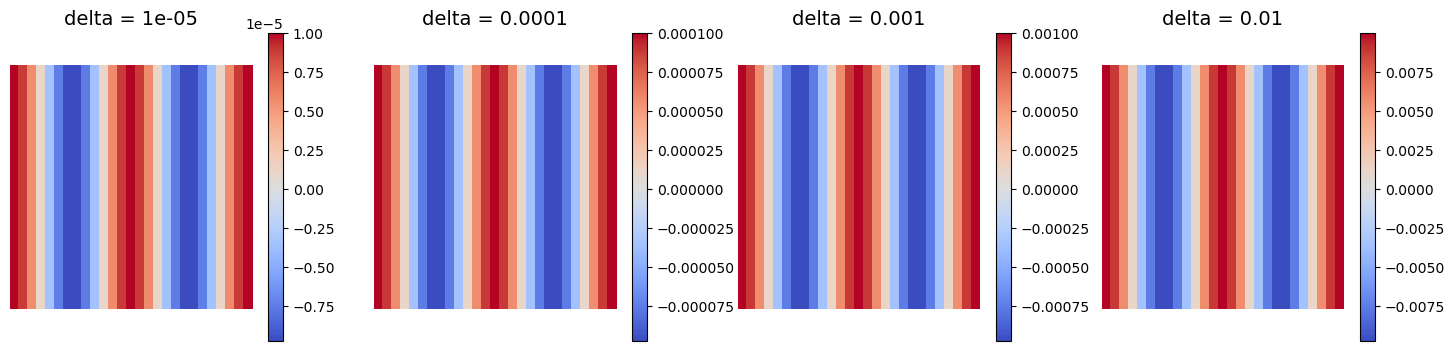

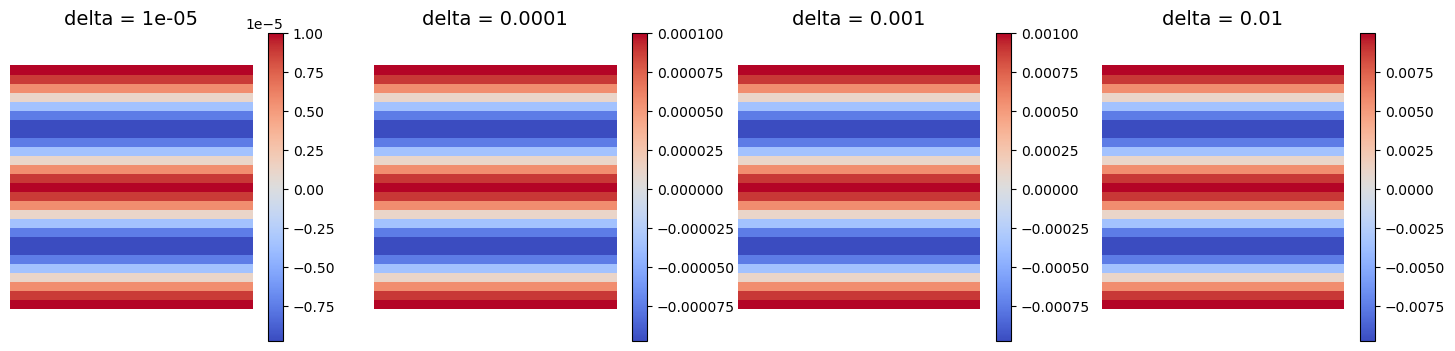

In [244]:
pstress = 0.1
x_bc = torch.ones((N,2))*Lmax
x_bc[:,1] = torch.linspace(0,Lmax,N).float()

x_bc = x_bc.to(device)
x_bc.requires_grad = True

C11_bc = C11[:,-1,0]
C33_bc = C33[:,-1,0]

fig1,ax1 = plt.subplots(1, 4, figsize=(18, 4), dpi=100)
fig2,ax2 = plt.subplots(1, 4, figsize=(18, 4), dpi=100)

deltas = [1e-5,1e-4,1e-3,1e-2]

Ux_ref, Uy_ref = u_exact(points_tensor,delta=1e-10)
Ux_ref = Ux_ref.reshape(N, N).cpu().detach().numpy()
Uy_ref = Uy_ref.reshape(N, N).cpu().detach().numpy()

for i,delta in enumerate(deltas):
    Ux_exact, Uy_exact = u_exact(points_tensor,delta=delta)
    im1 = pcolor_plot(ax1[i], X_plot, Y_plot, Ux_exact.reshape(N, N).cpu().detach().numpy()-Ux_ref, f"delta = {delta}",colormap="coolwarm")
    fig1.colorbar(im1,ax=ax1[i])
    im2 = pcolor_plot(ax2[i], X_plot, Y_plot, Uy_exact.reshape(N, N).cpu().detach().numpy()-Uy_ref, f"delta = {delta}",colormap="coolwarm")
    fig2.colorbar(im2,ax=ax2[i])
    E_exact = E_nn((Ux_exact,Uy_exact),points_tensor)

    Ubc_exact = u_exact(x_bc)

    E_bc = E_nn(Ubc_exact,x_bc)
    S_bc = S_nn(E_bc, C11_bc, C33_bc)
    bc_loss = torch.mean((S_bc[0] - pstress)**2)/len(x_bc) 

    print(f"{delta} : PDE {compute_PDE_loss(points_tensor, E_exact, C_data2):.3e} ; BC :{bc_loss}")
              

In [124]:
C33_bc.shape

torch.Size([27])

In [160]:
pstress = 0.1
x_bc = torch.ones((N,2))*Lmax
x_bc[:,1] = torch.linspace(0,Lmax,N).float()

x_bc = x_bc.to(device)
x_bc.requires_grad = True

Ubc_exact = u_exact(x_bc)
C11_bc = C11_batch[:,-1,0]
C33_bc = C33_batch[:,-1,0]

E_bc = E_nn(Ubc_exact,x_bc)
S_bc = S_nn(E_bc, C11_bc, C33_bc)
bc_loss = torch.mean((S_bc[0] - pstress)**2)/len(x_bc) 
ic(bc_loss)


Exx, Eyy, Exy = E_bc

Sxx = C11_bc * (Exx + Eyy) - 2*C33_bc * Eyy
Syy = C11_bc * (Exx + Eyy) - 2*C33_bc * Exx
Sxy = C33_bc * Exy


def S_nn(E, C11, C33):
    """
    Compute the stress for the given strain and stiffness coefficients.

    Parameters:
    - X (N*2): 2D spatial coordinates.
    - strain (N*3): Strains at each spatial coordinate (epsilon_x, epsilon_y, gamma_xy).
    - C11 (Nc*Nc): Coefficients for the stiffness matrix.
    - C33 (Nc*Nc): Coefficients for the stiffness matrix.
    - Lmax: Maximum limit for the 2D spatial grid.

    Returns:
    - stress (N*3): Stress at each spatial coordinate (sigma_x, sigma_y, tau_xy).
    """

    Exx, Eyy, Exy = E

    Sxx = C11 * (Exx + Eyy) - 2*C33 * Eyy
    Syy = C11 * (Exx + Eyy) - 2*C33 * Exx
    Sxy = 2*C33 * Exy

    return [Sxx, Syy, Sxy]

ic| bc_loss: tensor(2.2667e-14, grad_fn=<DivBackward0>)


In [147]:
Sxx = C11_bc[0] * (Exx[0] + Eyy[0]) - 2*C33_bc[0] * Eyy[0]
ic(C11_bc[0])
ic(Exx[0])
ic(Eyy[0])
ic(C33_bc[0])
ic(Sxx)

ic| C11_bc[0]: tensor(4.7115)
ic| Exx[0]: tensor(0.0257, grad_fn=<SelectBackward0>)
ic| Eyy[0]: tensor(-0.0107, grad_fn=<SelectBackward0>)
ic| C33_bc[0]: tensor(1.3716)
ic| Sxx: tensor(0.1000, grad_fn=<SubBackward0>)


tensor(0.1000, grad_fn=<SubBackward0>)